# veloVI analysis

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import cellrank as cr
import scvelo as scv
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
import velovi
from velovi import preprocess_data, VELOVI
import torch

Global seed set to 0


In [5]:
Path='/home/mgander/pancreas_multiome/data2'
adata=sc.read_h5ad(f'{Path}/Intestinal_epithelial_adata.h5ad')
adata

AnnData object with n_obs × n_vars = 118336 × 1807
    obs: 'sort_batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'batch', 'publication', 'sample_name', 'tissue', 'derive', 'detail_tissue', 'time', 'time2', 'main_cells', 'protocol', 'tech', 'tech_detail', 'molecular', 'gel', 'leiden', 'day'
    uns: 'leiden', 'level_1_colors', 'level_2_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scPoli', 'X_umap', 'X_umap_initial', 'X_umap_min', 'X_umap_sc'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Calculating RNA velocities

## scvelo steps

In [6]:
scv.pp.moments(adata, use_rep='X_scPoli')

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:02:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:38) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## veloVI steps

In [7]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:19) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [8]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)

In [9]:
#
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 252/500:  50%|███████████████████████████████▊                               | 252/500 [1:28:43<1:27:19, 21.13s/it, loss=-5.34e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -5498.078. Signaling Trainer to stop.


#### Check for convergence

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


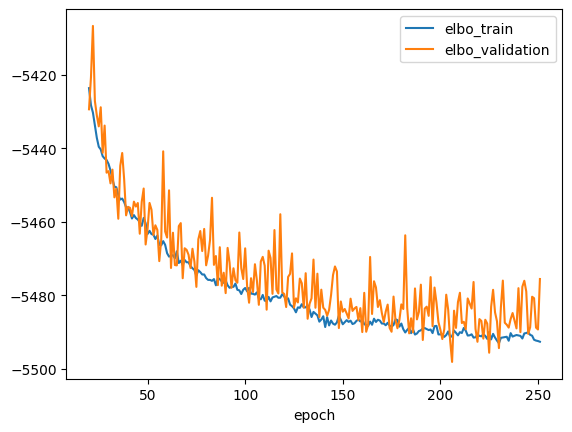

In [10]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [11]:
import torch
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [12]:
scv.tl.velocity_graph(adata, n_jobs=2)

computing velocity graph (using 2/32 cores)


  0%|          | 0/118336 [00:00<?, ?cells/s]

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:10:30) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


# Cellrank to determine terminal states

In [13]:
vk=cr.kernels.VelocityKernel(adata)

In [14]:
vk.compute_transition_matrix()

  0%|          | 0/118336 [00:00<?, ?cell/s]

  0%|          | 0/118336 [00:00<?, ?cell/s]

VelocityKernel[n=118336, model='deterministic', similarity='correlation', softmax_scale=18.166]

/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/mgander/miniconda3/envs/mc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


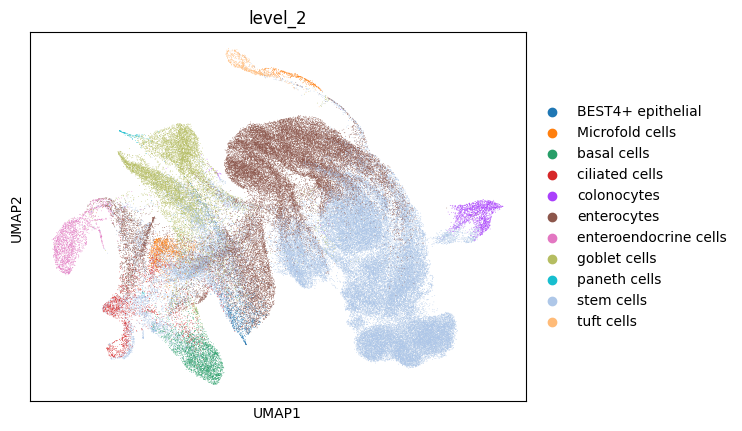

In [15]:
sc.pl.umap(adata, color='level_2')

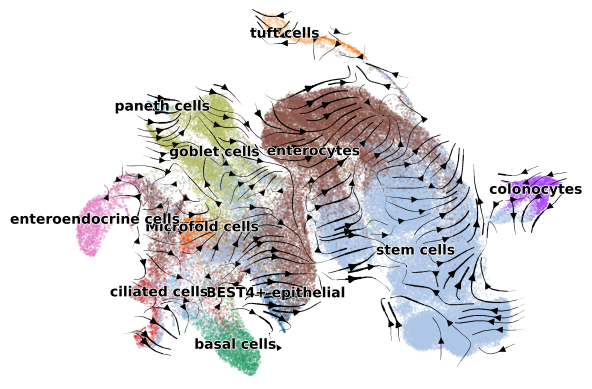

In [16]:
# This is the stream plot for only veloVI
vk.plot_projection(basis='X_umap', color="level_2", recompute=True, connectivities=adata.obsp['connectivities'], title='')

In [17]:
import pickle
tm=vk.transition_matrix
with open(f'{Path}/veloVI.pkl', 'wb') as handle:
    pickle.dump(tm, handle, protocol=pickle.HIGHEST_PROTOCOL)